In [1]:
!pip install mpld3

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px


import mpld3
from mpld3 import plugins

import warnings
warnings.filterwarnings('ignore')

#***************************************************************
#                   DEFINITION OF CONSTANTS
#***************************************************************

# Data path constant
DATA_PATH = "PisoFirme_AEJPol-20070024_household.dta"

# Dependent variables (dataset name)
DEP_VARS = ['S_shcementfloor', 
            'S_cementfloorkit', 
            'S_cementfloordin', 
            'S_cementfloorbat', 
            'S_cementfloorbed']

# Continuous control variables (dataset name)
CONT_CTRL_VARS = ['S_rooms',
                  'S_HHpeople',
                  'S_headeduc',
                  'S_spouseeduc',
                  'S_headage',
                  'S_spouseage',
                  'S_washhands',
                  'S_cashtransfers']

# Dummy NaN for continuous control variables (dataset name)
CONT_CTRL_VARS_NAN = [i + '_nan' for i in CONT_CTRL_VARS]

# Demographic control variables (dataset name)
DEMO_CTRL_VARS = ['S_dem'+str(i+1) for i in range(8)]

# Categorical control variables (dataset name)
DUMMY_CTRL_VARS = ['S_hasanimals',
                   'S_animalsinside',
                   'S_waterland',
                   'S_waterhouse',
                   'S_electricity',
                   'S_garbage',
                   'S_milkprogram',
                   'S_foodprogram',
                   'S_seguropopular']

# Dummy NaN for categorical control variables (dataset name)
DUMMY_CTRL_VARS_NAN = [i + '_nan' for i in DUMMY_CTRL_VARS]

# All control variables to generate NaN related dummies (dataset name) --> demographic variables not included
CTRL_VARS = CONT_CTRL_VARS + DUMMY_CTRL_VARS

# Variables for Model 1 linear regression (statsmodels name) --> single program dummy
MDL1_VARS = ['C(dpisofirme)']

# Variables for Model 2 linear regression (statsmodels name) --> add demographic and health control variables
MDL2_VARS = MDL1_VARS + CONT_CTRL_VARS[:7] + ['C('+i+')' for i in DUMMY_CTRL_VARS[:6]] \
                                           + ['C('+i+')' for i in CONT_CTRL_VARS_NAN[:7]] \
                                           + ['C('+i+')' for i in DUMMY_CTRL_VARS_NAN[:6]] \
                                           + DEMO_CTRL_VARS

# Variables for Model 3 linear regression (statsmodels name) --> add social program control variables
MDL3_VARS = MDL2_VARS + CONT_CTRL_VARS[-1:] + ['C('+i+')' for i in DUMMY_CTRL_VARS[-3:]] \
                                            + ['C('+i+')' for i in CONT_CTRL_VARS_NAN[-1:]] \
                                            + ['C('+i+')' for i in DUMMY_CTRL_VARS_NAN[-3:]] \

# Model variables without S_rooms for discussion part (statsmodels name)
MDL2_VARS_NOROOMS = [x for x in MDL2_VARS if x != 'S_rooms' and x != 'C(S_rooms_nan)']
MDL3_VARS_NOROOMS = [x for x in MDL3_VARS if x != 'S_rooms' and x != 'C(S_rooms_nan)']

# Names for table rows
ROWS = ['Share of rooms with cement floors',
        'Cement floor in kitchen',
        'Cement floor in dining room',
        'Cement floor in bathroom',
        'Cement floor in bedroom']

# Columns for the control group table
CG_COLUMNS = pd.MultiIndex.from_product([['Control Group'], ['Mean','Standard Deviation']])

# Program dummy name in statsmodels coefficients output
PROGRAMM_DUMMY = 'C(dpisofirme)[T.1.0]'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Load dataset
data = pd.read_stata(DATA_PATH)
# Drop households whose geographical informations is not complete (NaN)
data = data[data['idcluster'].notna()]
# Generate dummies for NaN values for all control variables except S_dem
data = pd.concat([data, pd.get_dummies(data[CTRL_VARS], columns=CTRL_VARS, dummy_na=True)[CONT_CTRL_VARS_NAN + DUMMY_CTRL_VARS_NAN]], axis=1) 
# Impute all NaN values with 0
data = data.fillna(0)
data

,dpisofirme,idcluster,coord_x,coord_y,idmun,idmza,C_blocksdirtfloor,C_HHdirtfloor,C_child05,C_households,C_people,C_rooms,C_HHpersons,C_waterland,C_waterhouse,C_waterbath,C_gasheater,C_refrigerator,C_washing,C_telephone,C_vehicle,C_overcrowding,C_poverty,C_illiterate,C_headeduc,C_dropouts515,C_employment,C_earnincome,S_HHpeople,S_headage,S_spouseage,S_headeduc,S_spouseeduc,S_rooms,S_waterland,S_waterhouse,S_electricity,S_cementfloor2000,S_hasanimals,S_animalsinside,...,S_dem5,S_dem6,S_dem7,S_dem8,S_seguropopular,S_shcementfloor,S_cementfloorkit,S_cementfloordin,S_cementfloorbat,S_cementfloorbed,S_satisfloor,S_satishouse,S_satislife,S_cesds,S_pss,S_instcement,S_instsanita,S_restsanita,S_constceili,S_restowalls,S_improveany,S_logrent,S_logsell,S_rooms_nan,S_HHpeople_nan,S_headeduc_nan,S_spouseeduc_nan,S_headage_nan,S_spouseage_nan,S_washhands_nan,S_cashtransfers_nan,S_hasanimals_nan,S_animalsinside_nan,S_waterland_nan,S_waterhouse_nan,S_electricity_nan,S_garbage_nan,S_milkprogram_nan,S_foodprogram_nan,S_seguropopular_nan
0,0.0,70000537.0,-103.503670,25.583067,7.0,40,0.300000,0.036629,0.555554,819.0,3530.0,3.097682,4.310134,0.002443,0.151522,0.272279,0.004885,0.114775,0.247868,0.524304,0.644129,1.731482,0.062267,0.045177,7.578925,0.092800,1.710631,1.610496,3.0,44.0,43.0,6.0,6.0,3,1,1,1,0.40,1.0,0.0,...,0.333333,0.00,0.333333,0.000000,0.0,0.6,1.0,0.0,1.0,0.0,1.0,1.0,1.0,14.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,5.298317,9.903487,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,70000537.0,-103.503670,25.583067,7.0,40,0.300000,0.036629,0.555554,819.0,3530.0,3.097682,4.310134,0.002443,0.151522,0.272279,0.004885,0.114775,0.247868,0.524304,0.644129,1.731482,0.062267,0.045177,7.578925,0.092800,1.710631,1.610496,2.0,37.0,0.0,6.0,0.0,1,1,1,1,0.75,0.0,0.0,...,0.500000,0.00,0.500000,0.000000,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,17.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,5.298317,9.615806,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,70000537.0,-103.503670,25.583067,7.0,40,0.300000,0.036629,0.555554,819.0,3530.0,3.097682,4.310134,0.002443,0.151522,0.272279,0.004885,0.114775,0.247868,0.524304,0.644129,1.731482,0.062267,0.045177,7.578925,0.092800,1.710631,1.610496,2.0,18.0,0.0,12.0,0.0,4,1,1,1,1.00,0.0,0.0,...,0.500000,0.00,0.500000,0.000000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,16.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,6.214608,10.819778,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,70000537.0,-103.503670,25.583067,7.0,47,0.300000,0.036629,0.555554,819.0,3530.0,3.097682,4.310134,0.002443,0.151522,0.272279,0.004885,0.114775,0.247868,0.524304,0.644129,1.731482,0.062267,0.045177,7.578925,0.092800,1.710631,1.610496,4.0,43.0,30.0,9.0,9.0,3,1,1,1,1.00,0.0,0.0,...,0.000000,0.00,0.250000,0.000000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,11.385092,11.918390,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.0,70000537.0,-103.503670,25.583067,7.0,47,0.300000,0.036629,0.555554,819.0,3530.0,3.097682,4.310134,0.002443,0.151522,0.272279,0.004885,0.114775,0.247868,0.524304,0.644129,1.731482,0.062267,0.045177,7.578925,0.092800,1.710631,1.610496,5.0,46.0,45.0,3.0,6.0,3,1,1,1,1.00,1.0,0.0,...,0.200000,0.00,0.400000,0.000000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.703783,10.819778,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2750,1.0,353150000.0,-103.399841,25.501871,35.0,40,0.538462,0.100774,0.759924,454.0,1866.0,3.264429,4.110127,0.011336,0.262172,0.333881,0.022024,0.113730,0.286599,0.660113,0.534601,1.655615,0.070493,0.035692,9.006986,0.116742,1.473560,1.418500,4.0,25.0,24.0,6.0,4.0,1,1,0,1,0.00,0.0,0.0,...,0.000000,0.25,0.250000,0.000000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,19.0,20.0,1.0,0.0,0.0,1.0,0.0,1.0,5.298317,9.615806,0,0,0,0,0,0,0,0,0,0,0,0,0

In [4]:
data_treatment = data[data['dpisofirme'] == 1]
data_treatment['dummy_cement'] = (data_treatment['S_cementfloor2000'] > data_treatment['S_cementfloor2000'].median()).astype(int)
data_treatment = data_treatment.reset_index()

# Make dataset with only happy and healthy variables
happy_dataset = data_treatment[['S_satisfloor', 'S_satishouse', 'S_satislife', 'S_cesds', 'S_pss']]
happy_dataset

,S_satisfloor,S_satishouse,S_satislife,S_cesds,S_pss
0,0.0,0.0,0.0,40.0,36.0
1,1.0,1.0,1.0,15.0,14.0
2,1.0,1.0,0.0,20.0,27.0
3,1.0,1.0,1.0,14.0,10.0
4,1.0,1.0,1.0,28.0,18.0
...,...,...,...,...,...
1357,1.0,1.0,1.0,19.0,20.0
1358,1.0,1.0,1.0,9.0,11.0
1359,1.0,1.0,1.0,12.0,19.0
1360,1.0,1.0,1.0,6.0,10.0


In [5]:
def cluster(model, X, **kwargs):
    """ Run a clustering model and return predictions.
    
    Args:
        model : {sklearn.cluster, sklearn.mixture, or hdbscan}
            Model to fit and predict
        X : pandas.DataFrame
            Data used to fit `model`
        **kwargs : `model`.fit_predict() args, optional
            Keyword arguments to be passed into `model`.fit_predict()
    Returns:
        (labels,centers) : tuple(array, pandas.DataFrame)
            A tuple containing cluster labels and a DataFrame of cluster centers formated with X columns
    """
    clust_fit = model.fit(X,**kwargs)
    clust_labels = model.fit_predict(X,**kwargs)
    centers = X.assign(**{model.__class__.__name__ : clust_labels} # assign a temp column to X with model name
                      ).groupby(model.__class__.__name__,sort=True).mean() # group on temp, gather mean of labels
    
    return (clust_labels, centers)

In [6]:
ac = AgglomerativeClustering(n_clusters=2, affinity = 'euclidean', linkage = 'ward')
clabels_ac,cent_ac = cluster(ac, happy_dataset)
happy_dataset['Happy'] = clabels_ac
happy_dataset

,S_satisfloor,S_satishouse,S_satislife,S_cesds,S_pss,Happy
0,0.0,0.0,0.0,40.0,36.0,1
1,1.0,1.0,1.0,15.0,14.0,0
2,1.0,1.0,0.0,20.0,27.0,1
3,1.0,1.0,1.0,14.0,10.0,0
4,1.0,1.0,1.0,28.0,18.0,1
...,...,...,...,...,...,...
1357,1.0,1.0,1.0,19.0,20.0,1
1358,1.0,1.0,1.0,9.0,11.0,0
1359,1.0,1.0,1.0,12.0,19.0,0
1360,1.0,1.0,1.0,6.0,10.0,0


In [7]:
from collections import Counter

fig, ax = plt.subplots(figsize=(10,10))

combos = list(zip(happy_dataset.S_pss.values, happy_dataset.S_cesds.values))
weight_counter = Counter(combos)

weights = [weight_counter[(happy_dataset.S_pss.values[i], happy_dataset.S_cesds.values[i])] for i, _ in enumerate(happy_dataset.S_pss.values)]
happy_dataset['Count'] = weights


labels = []

for i in range(len(happy_dataset)):
    label = happy_dataset.loc[[i], ['S_pss', 'S_cesds']].T
    label.columns = ['Households']
    label.index = ['Perceived Stress Scale', 'Depression Scale']
    labels.append(str(label.to_html()))

points = ax.scatter(happy_dataset.S_pss, happy_dataset.S_cesds, c=happy_dataset.Happy, s=20, cmap='bwr')
ax.set_xlabel('Perceived Stress Scale')
ax.xaxis.labelpad = 20
ax.set_ylabel('Depression Scale')
ax.yaxis.labelpad = 20
ax.legend(handles=points.legend_elements()[0], labels=['Happy', 'Unhappy'], loc='lower right', prop={'size': 15})

tooltip = plugins.PointHTMLTooltip(points, labels,
                                   voffset=10, hoffset=10)
plugins.connect(fig, tooltip)
mpld3.display()

In [8]:
filename = './aggplot.html'
mpld3.save_html(fig, filename, template_type='simple')

In [9]:
fig, ax = plt.subplots(figsize=(10,10))

counts = Counter([(x, y) for x, y in zip(happy_dataset.S_pss.values, happy_dataset.S_cesds.values)])

points_plot = set([(x, y) for x, y in zip(happy_dataset.S_pss.values, happy_dataset.S_cesds.values)])

a = list()
b = list()

for x, y in points_plot:
    a.append(x)
    b.append(y)


size = [counts[(x, y)] for x, y in zip(a, b)]

happy_colors = []

for i in points_plot:
  happy_colors.append(happy_dataset[(happy_dataset['S_cesds'] == i[1]) & (happy_dataset['S_pss'] == i[0])]['Happy'].values[0])

labels = []

for i in points_plot:
  label = pd.DataFrame(index=['Perceived Stress Scale', 'Depression Scale', 'Count'], columns=['Household'])
  label.loc['Perceived Stress Scale', 'Household'] = i[0]
  label.loc['Depression Scale', 'Household'] = i[1]
  label.loc['Count', 'Household'] = counts[i]
  labels.append(str(label.to_html()))

points = ax.scatter(*zip(*points_plot), alpha=0.75, s=[14*e for e in size], c=happy_colors, cmap='bwr')
ax.set_xlabel('Perceived Stress Scale')
ax.xaxis.labelpad = 20
ax.set_ylabel('Depression Scale')
ax.yaxis.labelpad = 20
ax.legend(handles=points.legend_elements()[0], labels=['Happy', 'Unhappy'], loc='lower right', prop={'size': 15})

tooltip = plugins.PointHTMLTooltip(points, labels,
                                   voffset=10, hoffset=10)
plugins.connect(fig, tooltip)
mpld3.display()

In [10]:
filename = './aggplot_counts_final.html'
mpld3.save_html(fig, filename, template_type='simple')

In [11]:
y0 = happy_dataset[happy_dataset['Happy'] == 0]['S_pss'].values
y1 = happy_dataset[happy_dataset['Happy'] == 1]['S_pss'].values

fig = go.Figure()

fig.add_trace(go.Box(y=y0, name='Happy',
                marker_color = 'blue', boxpoints='all'))
fig.add_trace(go.Box(y=y1, name = 'Unhappy',
                marker_color = 'red', boxpoints='all'))

fig.update_layout(yaxis_title='Perceived Stress Scale', autosize=False, width=800, height=800,)
fig.show()

In [12]:
fig.write_html("./boxplot_pss.html")

In [13]:
y0 = happy_dataset[happy_dataset['Happy'] == 0]['S_cesds'].values
y1 = happy_dataset[happy_dataset['Happy'] == 1]['S_cesds'].values

fig = go.Figure()

fig.add_trace(go.Box(y=y0, name='Happy',
                marker_color = 'blue', boxpoints='all'))
fig.add_trace(go.Box(y=y1, name = 'Unhappy',
                marker_color = 'red', boxpoints='all'))

fig.update_layout(yaxis_title='Depression Scale', autosize=False, width=800, height=800,)
fig.show()

In [14]:
fig.write_html("./boxplot_cesds.html")

# **Plot les satisfactions avec depression scale en X**



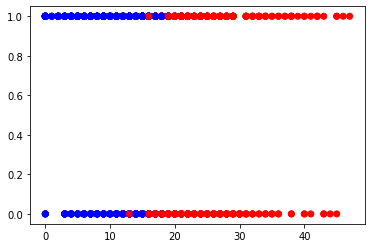

In [15]:
plt.scatter(happy_dataset.S_cesds, happy_dataset.S_satislife, c=happy_dataset.Happy, cmap='bwr')

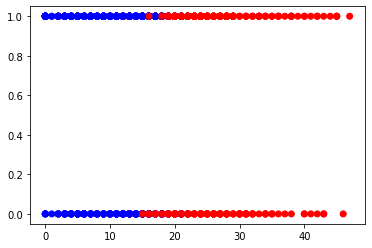

In [16]:
plt.scatter(happy_dataset.S_cesds, happy_dataset.S_satisfloor, c=happy_dataset.Happy, cmap='bwr')

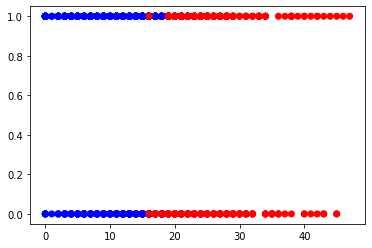

In [17]:
plt.scatter(happy_dataset.S_cesds, happy_dataset.S_satishouse, c=happy_dataset.Happy, cmap='bwr')

# **Plot les satisfactions avec stress scale en X**




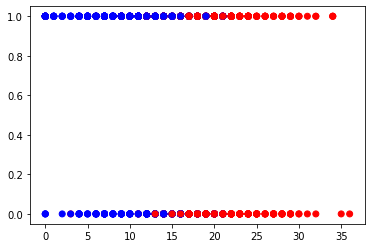

In [18]:
plt.scatter(happy_dataset.S_pss, happy_dataset.S_satislife, c=happy_dataset.Happy, cmap='bwr')

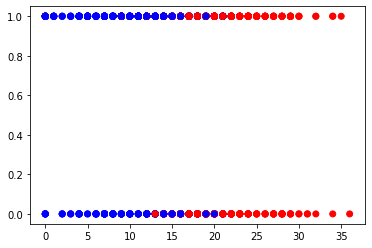

In [19]:
plt.scatter(happy_dataset.S_pss, happy_dataset.S_satisfloor, c=happy_dataset.Happy, cmap='bwr')

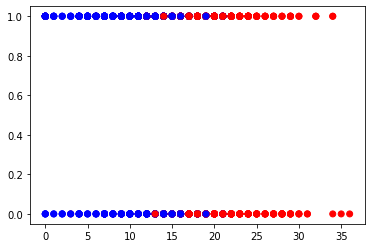

In [21]:
plt.scatter(happy_dataset.S_pss, happy_dataset.S_satishouse, c=happy_dataset.Happy, cmap='bwr')